# Attempting to fit flux time series to various characteristical curves and use their coeffs as features

### Useful work:

- http://astro.uchicago.edu/~frieman/Courses/A411-old/References/supernova-photometric-classification-1008.1024.pdf?fbclid=IwAR1jnLflM2OXY3mXEb3ZzZ_jdXYczsRn-90hMCX7lNghn3JXe_n42voz4OE
- https://www.kaggle.com/c/PLAsTiCC-2018/discussion/73572
- https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated
- https://www.kaggle.com/mithrillion/strategies-for-flux-time-series-preprocessing
- https://docs.scipy.org/doc/scipy/reference/signal.html
- https://en.wikipedia.org/wiki/Dynamic_time_warping

### Feature generation experiments
Not implemented outside of this notebook yet

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

In [ ]:
df = dd.read_csv('../../data/raw/test_set.csv')

In [ ]:
%%time
passband_aggregates = df.groupby('passband').flux.agg(['min', 'max', 'mean', 'std']).compute()

In [ ]:
freq = pd.DataFrame({
    0: [300,400],
    1: [400,600],
    2: [500,700],
    3: [650,850],
    4: [800,950],
    5: [950,1050],
}, index=['min', 'max'])
freq.loc['mean'] = freq.mean()
freq = freq.transpose().add_prefix('freq_')

In [ ]:
passband_meta = passband_aggregates.add_prefix('flux_').join(freq)

In [ ]:
test_meta = pd.read_csv('../../data/raw/test_set_metadata.csv')

In [ ]:
redshift = test_meta.agg({'hostgal_photoz': ['mean', 'min', 'max', 'std']})

In [ ]:
train = pd.read_csv('../../data/raw/training_set.csv')
train_meta = pd.read_csv('../../data/raw/training_set_metadata.csv')

In [ ]:
train_aggregates = train.groupby('passband').flux.agg(['min', 'max', 'mean', 'std']).add_prefix('train_flux_')
train_redshift = train_meta.agg({'hostgal_photoz': ['mean', 'min', 'max', 'std']}).add_prefix('train_')

In [114]:
passband_meta = passband_meta.join(train_aggregates)

In [115]:
redshift_meta = redshift.join(train_redshift)

In [116]:
passband_meta

,flux_min,flux_max,flux_mean,flux_std,freq_min,freq_max,freq_mean,train_flux_min,train_flux_max,train_flux_mean,train_flux_std
passband,,,,,,,,,,,
0,-8.935484e+06,1.367579e+07,3.486876,16904.505340,300.0,400.0,350.0,-1.149388e+06,2.432809e+06,21.871795,7625.403812
1,-1.440740e+05,2.521541e+05,3.621615,1021.469816,400.0,600.0,500.0,-3.657252e+04,1.728294e+05,21.050868,1093.284525
2,-7.443788e+04,2.036998e+05,6.540808,778.074806,500.0,700.0,600.0,-1.939117e+04,3.842410e+05,37.078660,2339.649282
3,-9.078573e+04,2.826358e+05,7.538213,650.457695,650.0,850.0,750.0,-4.418473e+04,4.786452e+05,33.123413,2477.230889
4,-1.166522e+05,7.251493e+05,7.202244,726.519569,800.0,950.0,875.0,-8.753470e+04,5.342851e+05,25.322441,2577.226679
5,-2.009988e+05,6.350717e+05,6.994828,853.411579,950.0,1050.0,1000.0,-1.269998e+05,6.142572e+05,11.657914,3182.773739


In [117]:
redshift_meta

,hostgal_photoz,train_hostgal_photoz
mean,0.516816,0.357885
min,0.000000,0.000000
max,3.000000,2.999400
std,0.449134,0.545552


In [118]:
# these are some important readings, make sure to save them
passband_meta.to_csv('../../data/features/passband-meta.csv')
redshift_meta.to_csv('../../data/features/redshift-meta.csv')

Improving passband meaning by calculating source frequency based on redshift will impact test performance even more than train performance

In [3]:
passband_meta = pd.read_csv('../../data/features/passband-meta.csv')
redshift_meta = pd.read_csv('../../data/features/redshift-meta.csv')

In [14]:
passband_freq = passband_meta[[col for col in passband_meta if 'freq' in col]].copy()

In [15]:
high_confidence_threshold = (passband_freq['freq_mean'] - passband_freq['freq_min']) * 0.67
passband_freq['freq_high_conf_min'] = passband_freq['freq_mean'] - high_confidence_threshold
passband_freq['freq_high_conf_max'] = passband_freq['freq_max'] + high_confidence_threshold
passband_freq

,freq_min,freq_max,freq_mean,freq_high_conf_min,freq_high_conf_max
0,300.0,400.0,350.0,316.50,433.50
1,400.0,600.0,500.0,433.00,667.00
2,500.0,700.0,600.0,533.00,767.00
3,650.0,850.0,750.0,683.00,917.00
4,800.0,950.0,875.0,824.75,1000.25
5,950.0,1050.0,1000.0,966.50,1083.50


In [37]:
list(passband_freq['freq_mean'])

[350.0, 500.0, 600.0, 750.0, 875.0, 1000.0]

In [1]:
import pandas as pd
import numpy as np
from numba import jit, float32, float64, int32, int64

In [46]:
@jit(["int32(int32, float32)", "int64(int64, float64)"], nopython=True)
def fix_passband(raw_passband: int, redshift: float):
    """ 
    Moving from raw passband r to passband p, if: 
    redshift offset x high confidence min freq of r <= min freq of p, 
    redshift offset x and high confidence max freq of r >= max freq of p
    """
    freq_mean = np.array([350.0, 500.0, 600.0, 750.0, 875.0, 1000.0])
    freq_min = np.array([300.0, 400.0, 500.0, 650.0, 800.0, 950.0])
    freq_max = np.array([400.0, 600.0, 700.0, 850.0, 950.0, 1050.0])
    mean_with_offset = (1+redshift) * freq_mean[raw_passband]
    for i in range(6):
        if mean_with_offset > freq_min[i] and mean_with_offset < freq_max[i]:
            return i
    return np.nan

@jit(["int32[:](float32[:,:])", "int64[:](float64[:,:])"])
def fix_passband_vct(passband_and_redshift_):
    result = np.zeros(passband_and_redshift_.shape[0]).astype(np.int)
    for i in range(passband_and_redshift_.shape[0]):
        result[i] = fix_passband(passband_and_redshift_[i][0].astype(np.int), passband_and_redshift_[i][1])
    return result

In [52]:
ones = np.ones(5000000, dtype=np.int) # 1/10000 of the test set, more or less
rss = np.random.rand(5000000)
df_time_test = pd.DataFrame({'ones': ones, 'rss': rss})

In [53]:
%%time
fix_passband_vct(df_time_test.values)[:10]

CPU times: user 17.3 s, sys: 52 ms, total: 17.3 s
Wall time: 17.3 s


array([3, 3, 4, 3, 3, 5, 1, 3, 3, 4])

In [54]:
df_time_test.head(10)

,ones,rss
0,1,0.608068
1,1,0.550315
2,1,0.777934
3,1,0.442073
4,1,0.507400
5,1,0.989552
6,1,0.115404
7,1,0.477823
8,1,0.504899
9,1,0.877799


In [24]:
redshift_meta['hostgal_photoz_mapped'] = redshift_meta.index.map(redshift_meta['hostgal_photoz'])

NameError: name 'redshift_meta' is not defined

### Generation of features

Already implemented in featurize.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Set
from datetime import datetime as dt

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [4]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [5]:
%%time
meta_train = process_meta('../../data/raw/training_set_metadata.csv')
train = pd.read_csv('../../data/raw/training_set.csv')

CPU times: user 2.98 s, sys: 652 ms, total: 3.63 s
Wall time: 3.62 s


In [48]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=16)

Preprocessing time...
Fixing passband alignment...
Generating custom features...
Custom features generated.


Feature Extraction: 100%|██████████| 80/80 [00:02<00:00, 34.46it/s]


CPU times: user 2min 53s, sys: 5.87 s, total: 2min 59s
Wall time: 3min


In [50]:
3.25*350/60  # hrs to featurize entire test set

18.958333333333332

In [51]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [52]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 54.6 ms


In [53]:
X.shape

(7848, 181)

In [54]:
y.shape

(7848,)

### Train model with CV

In [55]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 2048,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.02137,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [56]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore]

colanmes_to_ignore_no_raw_data_peaks = colnames_to_ignore_very_restrictive | set([col for col in X.columns if 'peak' in col and not 'period' in col])

colnames_to_ignore_no_custom_series_for_fpb = colnames_to_ignore_restrictive | set([col for col in X.columns if '_fpb' in col and not '__' in col])

colnames_to_ignore_final = colanmes_to_ignore_no_raw_data_peaks | colnames_to_ignore_no_custom_series_for_fpb

id_colname = 'object_id'

In [57]:
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore_final]

In [58]:
X[feature_colnames].shape

(7848, 146)

In [ ]:
%%time
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params={
        'lgbm': lgbm_params
    }, 
    nr_fold=6, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.403363	training's wloss: 0.903578	valid_1's multi_logloss: 1.75736	valid_1's wloss: 1.1103
[200]	training's multi_logloss: 0.206011	training's wloss: 0.588198	valid_1's multi_logloss: 1.35755	valid_1's wloss: 0.827918
[300]	training's multi_logloss: 0.147582	training's wloss: 0.46307	valid_1's multi_logloss: 1.17598	valid_1's wloss: 0.743969
[400]	training's multi_logloss: 0.119446	training's wloss: 0.392402	valid_1's multi_logloss: 1.07467	valid_1's wloss: 0.718419
[500]	training's multi_logloss: 0.102167	training's wloss: 0.346105	valid_1's multi_logloss: 1.01095	valid_1's wloss: 0.708514
[600]	training's multi_logloss: 0.0895134	training's wloss: 0.310561	valid_1's multi_logloss: 0.966467	valid_1's wloss: 0.703469
[700]	training's multi_logloss: 0.0796326	training's wloss: 0.282068	valid_1's multi_logloss: 0.932047	valid_1's wloss: 0.708096
Early stopping, best iteration is:
[601]	traini

In [ ]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(60), x='gain', y='feature', hue='fold', )
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(250), x='gain', y='feature', hue='fold', )
plt.show()

In [ ]:
[col for col in X.columns if '_fpb' in col and not '__' in col]

### Working on scaled flux

In [24]:
scaling_series = pd.Series(meta_train['hostgal_photoz'], index=meta_train['object_id']).fillna(0)
scaling_series.head(12)

object_id
615     0.0000
713     0.2139
730     0.5002
745     1.6654
1124    0.0000
1227    0.0985
1598    0.4446
1632    0.4897
1920    0.5783
1926    0.3816
2072    0.2382
2103    0.5041
Name: hostgal_photoz, dtype: float64

In [25]:
from tqdm.autonotebook import tqdm

In [26]:
train_experiment = train.copy()

In [27]:
%%time
gbo = train_experiment.groupby('object_id')
for idx_, df_ in tqdm(gbo, total=len(train_experiment['object_id'].unique())):
    scale_factor = scaling_series.loc[idx_]
    new_flux = df_['flux'] * ((1+scale_factor)**2)
    new_flux_err = df_['flux_err'] * ((1+scale_factor)**2)
    train_experiment.loc[train_experiment['object_id'] == idx_, 'flux'] = new_flux
    train_experiment.loc[train_experiment['object_id'] == idx_, 'flux_err'] = new_flux_err


CPU times: user 7min 8s, sys: 2.2 s, total: 7min 11s
Wall time: 7min 7s


##### Performing featurization once again

In [28]:
%%time
Xsf = featurize(train_experiment, meta_train, aggs, fcp, n_jobs=4)

Preprocessing time...
Fixing passband alignment...
Generating custom features...
Custom features generated.


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


CPU times: user 3min 27s, sys: 8.14 s, total: 3min 35s
Wall time: 3min 45s


In [29]:
3.5*350/60  # hrs to featurize entire test set

20.416666666666668

In [30]:
if 'target' in Xsf:
    y = Xsf['target']
    del Xsf['target']
else:
    print("What the duck")
    3//0

In [31]:
%%time
train_mean = Xsf.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
Xsf.fillna(0, inplace=True)

CPU times: user 72 ms, sys: 24 ms, total: 96 ms
Wall time: 97 ms


In [32]:
Xsf.shape

(7848, 189)

In [33]:
y.shape

(7848,)

##### Train model with CV

In [35]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 8,
    'max_depth': 6,
    'n_estimators': 4096,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.01237,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 25.,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [36]:
X[feature_colnames].shape

(7848, 154)

In [37]:
Xsf[feature_colnames].shape

(7848, 154)

In [38]:
%%time
clfs, score, importances = train_and_validate(
    X=Xsf, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params={
        'lgbm': lgbm_params
    }, 
    nr_fold=6, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.660654	training's wloss: 1.25787	valid_1's multi_logloss: 2.17537	valid_1's wloss: 1.43394
[200]	training's multi_logloss: 0.35118	training's wloss: 0.829698	valid_1's multi_logloss: 1.69696	valid_1's wloss: 1.04139
[300]	training's multi_logloss: 0.233656	training's wloss: 0.640761	valid_1's multi_logloss: 1.45857	valid_1's wloss: 0.872622
[400]	training's multi_logloss: 0.178666	training's wloss: 0.535662	valid_1's multi_logloss: 1.31155	valid_1's wloss: 0.787009
[500]	training's multi_logloss: 0.147876	training's wloss: 0.467403	valid_1's multi_logloss: 1.21053	valid_1's wloss: 0.740815
[600]	training's multi_logloss: 0.128225	training's wloss: 0.419941	valid_1's multi_logloss: 1.14048	valid_1's wloss: 0.71663
[700]	training's multi_logloss: 0.114367	training's wloss: 0.384455	valid_1's multi_logloss: 1.08853	valid_1's wloss: 0.699178
[800]	training's multi_logloss: 0.103907	training's w

KeyboardInterrupt: 

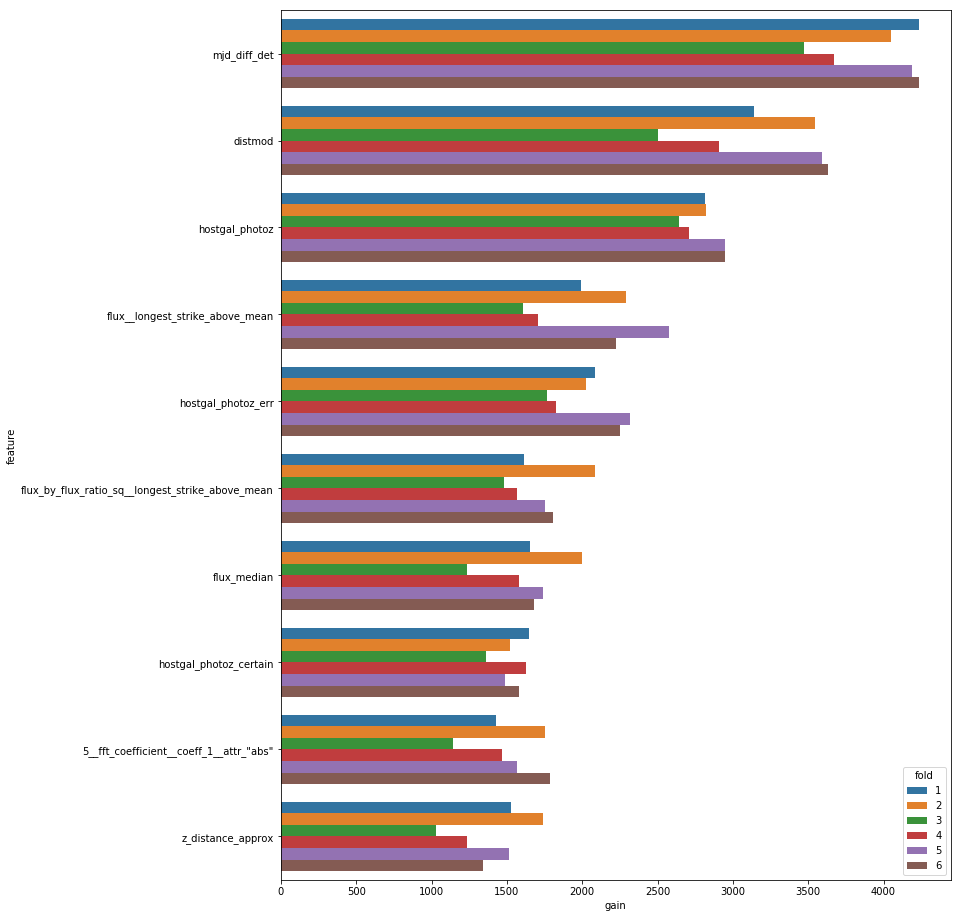

In [21]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(60), x='gain', y='feature', hue='fold', )
plt.show()

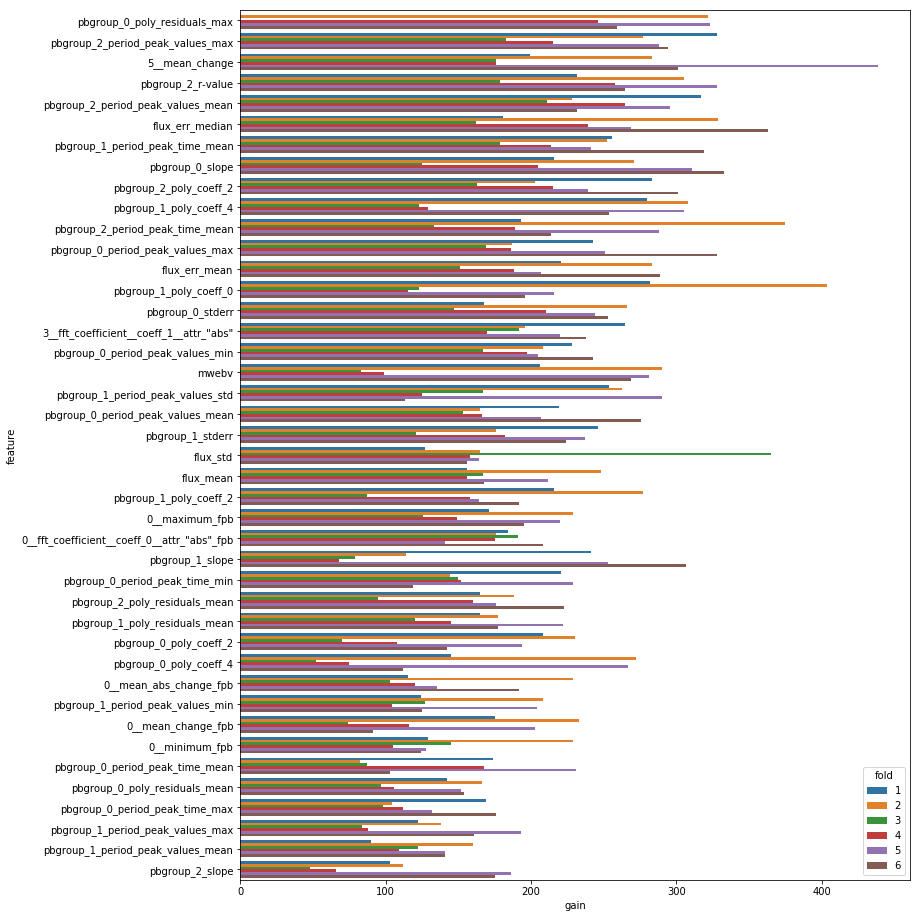

In [22]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(250), x='gain', y='feature', hue='fold', )
plt.show()

In [23]:
[col for col in X.columns if '_fpb' in col and not '__' in col]

[]

### Combining both feature sets
TODO: Combine features that will be generated from the scripts running on the test set

### PCA
TODO: Use PCA to reduce dimensions and re-train the  model on both feature sets

### Generate features for the test set

In [21]:
sorted_importances = importances.groupby('feature').mean().sort_values(by='mean_gain', ascending=False)

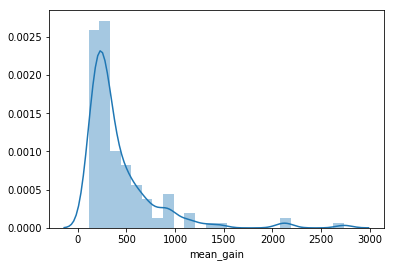

In [22]:
sns.distplot(sorted_importances['mean_gain'])

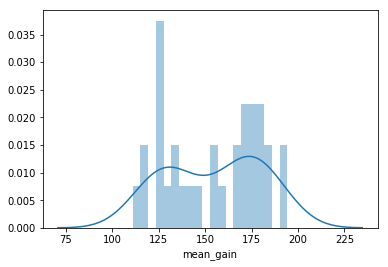

In [23]:
sns.distplot(sorted_importances[sorted_importances['mean_gain'] < 200.]['mean_gain'], bins=20)

In [24]:
new_features_to_drop = sorted_importances[sorted_importances['mean_gain'] < 100.].index.unique()

In [25]:
new_features_to_drop

Index([], dtype='object', name='feature')

### Featurize the test set

In [26]:
chunk_size_one_100 = 453653105 // 100 + 1
# chunk_size_one_100 = 1000001 // 100 + 1
chunk_size_one_100

4536532

In [37]:
from datetime import datetime
datetime.now()  # should take no more than 12hrs

datetime.datetime(2018, 12, 14, 20, 12, 17, 563401)

In [46]:
X1 = X.iloc[:4000].copy()
X2 = X.iloc[4000:].copy()

In [51]:
X.shape

(7848, 156)

In [50]:
pd.concat([X1,X2]).shape

(7848, 156)

In [ ]:
%%time
# should take 100x (time after 1st iteration)
featurize_test(
    featurize_configs={'aggs': aggs, 'fcp': fcp}, 
    n_jobs=16,
    meta_path='../../data/raw/test_set_metadata.csv',
    test_path='../../data/raw/test_set.csv',
    output_path='../../data/features/test-3band-series-models.csv',
    id_colname='object_id',
    chunks=chunk_size_one_100,  # alternatively: 5000000
)

In [39]:
print("Done.")

Done.
